In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from pprint import pprint
import pickle

In [4]:
from wordcloud import WordCloud # using the WordCloud master version from git
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english')) | set(['also', 'even', 'etc', 'either'])

# If we already have the file, go to <a href="#after_merge">this cell</a>

### Setup the category -> product

In [5]:
with open("data/productcategories.pickle", "rb") as f:
    all_cats = pickle.load(f)

Why are there double lists ? Let's inspect:

In [6]:
max_len = 0
prod_id = ''
for (prod, cats) in all_cats.items():
    if len(cats) > max_len:
        max_len = len(cats)
        prod_id = prod
pprint(all_cats[prod_id])

[['sports & outdoors', 'accessories', 'sport watches'],
 ['clothing, shoes & jewelry', 'new arrivals'],
 ['clothing, shoes & jewelry', 'jewelry: international shipping available'],
 ['clothing, shoes & jewelry', 'luxury watches'],
 ['clothing, shoes & jewelry', 'available for international shipping'],
 ['clothing, shoes & jewelry', 't', 'tag heuer'],
 ['clothing, shoes & jewelry', 'sport watches'],
 ['clothing, shoes & jewelry', 'women', 'watches', 'wrist watches'],
 ['clothing, shoes & jewelry', 'men'],
 ['clothing, shoes & jewelry', "women's athletic watches"],
 ['clothing, shoes & jewelry', "men's athletic watches"],
 ['clothing, shoes & jewelry', "women's luxury brands"]]


Reduce the category data to have just the main ones, in a simple list. Also removes duplicates

In [7]:
prods_cats = []
for prod, trees in all_cats.items():
    outer_cats = set()
    for cat_tree in trees:
        outer_cats.add(cat_tree[0])
    for cat in outer_cats:
        prods_cats.append((prod.upper(), cat))

In [8]:
categories = pd.DataFrame(prods_cats, columns=['asin', 'Category']).set_index('Category')
categories.head()

,asin
Category,
electronics,B001MS2RDM
home & kitchen,B000MF60A2
sports & outdoors,B000UGUAQ8
automotive,B005BNHTXC
baby,B00003CW8K


In [9]:
categories.index.unique()

array(['electronics', 'home & kitchen', 'sports & outdoors', 'automotive',
       'baby', 'grocery & gourmet food', 'tools & home improvement',
       'clothing, shoes & jewelry', 'patio, lawn & garden',
       'health & personal care', 'beauty', 'office products',
       'toys & games', 'industrial & scientific', 'pet supplies',
       'cell phones & accessories', 'computers', 'baby products',
       'arts, crafts & sewing', 'video games', 'cds & vinyl',
       'amazon fashion', 'movies & tv', 'musical instruments',
       'all beauty', 'appliances', 'all electronics',
       'office & school supplies', 'kitchen & dining',
       'collectibles & fine art', 'home improvement'], dtype=object)

### Setup review -> product

In [10]:
revs_arr = []
with open('data/swiss_reviews.txt') as f:
    for entry in f:
        revs_arr.append(eval(entry))

In [11]:
revs = pd.DataFrame(revs_arr).set_index('asin')
revs.head(3)

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
asin,,,,,,,,
B003U8ENTI,"[0, 0]",5.0,"Perfect fit, charged well, worked first time, ...","05 4, 2013",A00027081JC8NE8X6TD5,Kevin Corse,Well done and affordable,1367625600
B004JW1B8A,"[0, 0]",1.0,I really thought it would be a nice tote bage....,"12 3, 2012",A00090122PEQW7864EC8L,Barbara Evans,Justin Bieber Tote Bag,1354492800
B000I7GST2,"[1, 1]",5.0,"i like it so much, i hope Kuhn Rikon is availa...","07 2, 2013",A0009686KROLKEH2EHF4,shahrizal abdullah,Very stylish and practical to use,1372723200


In [12]:
revs['reviewTime'] = pd.to_datetime(revs.unixReviewTime, unit='s')
revs.drop('unixReviewTime', axis=1, inplace=True)
revs.head(3)

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary
asin,,,,,,,
B003U8ENTI,"[0, 0]",5.0,"Perfect fit, charged well, worked first time, ...",2013-05-04,A00027081JC8NE8X6TD5,Kevin Corse,Well done and affordable
B004JW1B8A,"[0, 0]",1.0,I really thought it would be a nice tote bage....,2012-12-03,A00090122PEQW7864EC8L,Barbara Evans,Justin Bieber Tote Bag
B000I7GST2,"[1, 1]",5.0,"i like it so much, i hope Kuhn Rikon is availa...",2013-07-02,A0009686KROLKEH2EHF4,shahrizal abdullah,Very stylish and practical to use


In [13]:
print(len(revs.index.unique()))
print(len(categories.asin.unique()))

10002
10002


In [14]:
revs_cats = pd.merge(revs, categories, right_on='asin', left_index=True)
revs_cats.head()

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,asin
Category,,,,,,,,
electronics,"[0, 0]",5.0,"Perfect fit, charged well, worked first time, ...",2013-05-04,A00027081JC8NE8X6TD5,Kevin Corse,Well done and affordable,B003U8ENTI
electronics,"[0, 0]",3.0,I have not received this product yet. Will let...,2012-11-20,A033343523Z8KJ4WKGUBJ,David W. Brown,Battery review,B003U8ENTI
electronics,"[1, 1]",1.0,The battery dies 45 days after purchase. Amazo...,2014-06-08,A10YQAG3J313HS,J. Bernard,Battery died within 45 days.,B003U8ENTI
electronics,"[0, 0]",5.0,"When it's too late to buy OEM batteries, this ...",2013-05-10,A11DS1II7Z6R3H,Mark Twain,Great replacement battery,B003U8ENTI
electronics,"[0, 0]",5.0,This product met all my expectations and it ar...,2014-07-11,A11OZBD3TCQGUF,"J. Gesink ""SHD""",Five Stars,B003U8ENTI


In [15]:
# revs_cats.to_csv('data/revs_with_categories.csv')

## If we came from start of Notebook, just load from file <a id="after_merge">

In [16]:
try: revs_cats
except NameError:
    revs_cats = pd.read_csv('data/revs_with_categories.csv', index_col=0, parse_dates=['reviewTime'])

We need to do some cleaning, as there are duplicates and empty reviews (which we can ignore for wordclouds)

In [17]:
print(sum(revs_cats.duplicated(subset='reviewText')))
revs_cats.drop_duplicates(subset='reviewText', inplace=True)

48114


That's quite a lot of duplicated text ! :o . Fake reviews ? 

In [18]:
print(revs_cats.reviewText.isnull().sum()) # the duplicate removal also took 'nan' out, but not 'NaN'
revs_cats.dropna(axis='index', subset=['reviewText'], inplace=True)

0


In [19]:
revs_groups = revs_cats.groupby(level=0)
print(len(revs_groups))
print(revs_groups.groups.keys())

31
dict_keys(['electronics', 'automotive', 'beauty', 'office & school supplies', 'movies & tv', 'grocery & gourmet food', 'office products', 'industrial & scientific', 'collectibles & fine art', 'computers', 'toys & games', 'all beauty', 'home & kitchen', 'baby products', 'video games', 'amazon fashion', 'all electronics', 'sports & outdoors', 'baby', 'health & personal care', 'musical instruments', 'appliances', 'kitchen & dining', 'pet supplies', 'clothing, shoes & jewelry', 'tools & home improvement', 'cds & vinyl', 'patio, lawn & garden', 'cell phones & accessories', 'arts, crafts & sewing', 'home improvement'])


In [38]:
from cloud_utilities import *

In [26]:
electro_freq, num_pos, num_neg = process_cat(electro_df, WordCloud())

Corpora done 0.16388440132141113
Processing done 52.872467041015625


In [29]:
electro_wc = WordCloud(width=800, height=800, min_font_size=2, scale=1, relative_scaling=1)
electro_wc.fit_words(electro_freq.total.to_dict())

Test some different color functions

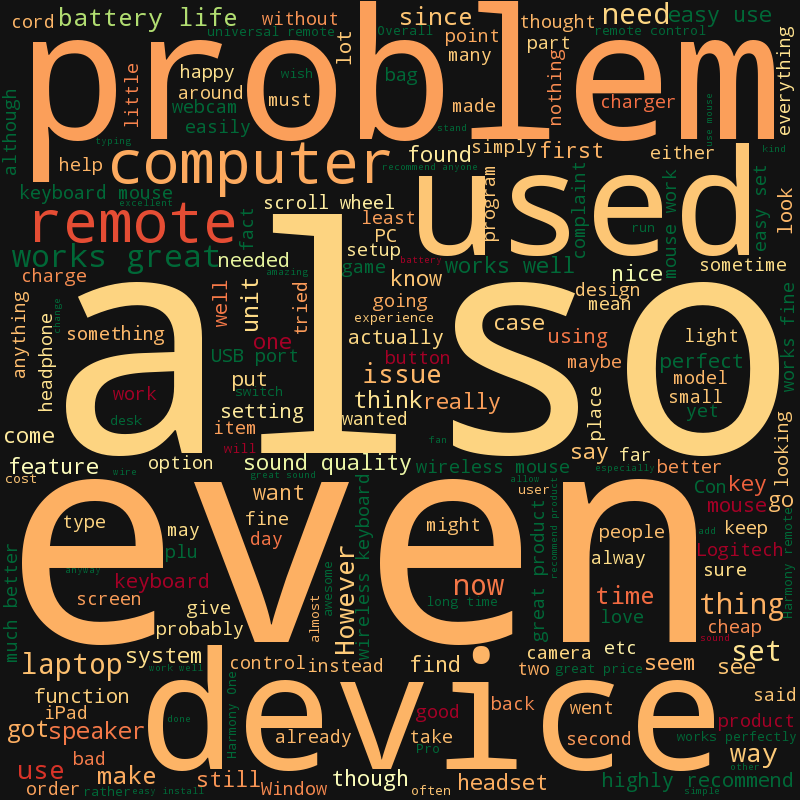

In [32]:
# electro_wc.color_func = get_brewer_color_func(electro_freq, num_pos, num_neg)
electro_wc.background_color = "#121212"
electro_wc.color_func = get_cmap_color_func(electro_freq, num_pos, num_neg, 'RdYlGn')
electro_wc.recolor()
electro_wc.to_image()

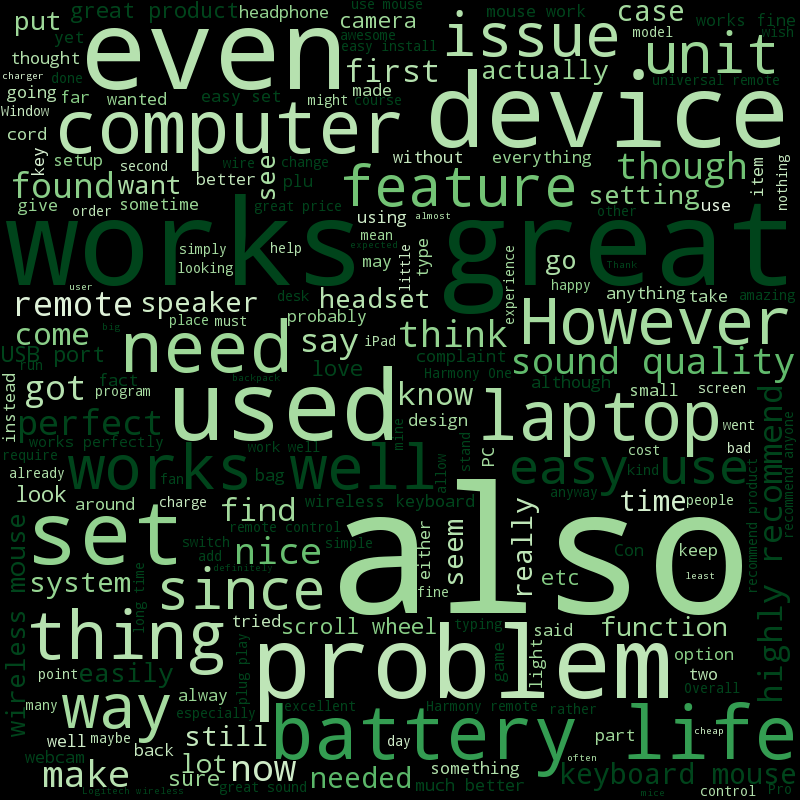

In [33]:
pos_wc = WordCloud(height=800, width=800, max_words=1600, scale=1, collocations=True, relative_scaling=1,
                   stopwords=stopwords)
pos_wc.color_func = get_cmap_color_func(electro_freq, num_pos, num_neg, 'Greens')
pos_wc.fit_words(electro_freq.pos.to_dict())
pos_wc.to_image()

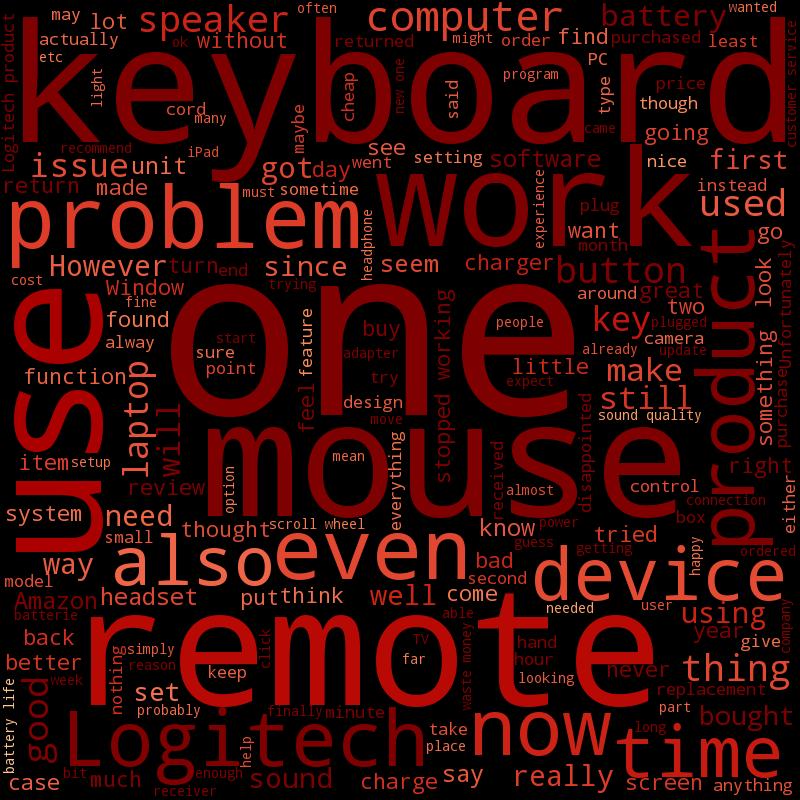

In [34]:
neg_wc = WordCloud(height=800, width=800, max_words=1600, scale=1, collocations=True, relative_scaling=1,
                   stopwords=stopwords)
neg_wc.color_func = get_cmap_color_func(electro_freq, num_pos, num_neg, 'OrRd_r')
neg_wc.fit_words(electro_freq.neg.to_dict())
neg_wc.to_image()

In [41]:
def process_group(group, save=True, check_exists=True, num_items=None):
    """ Creates all the wordclouds for all the categories in `group` """
    from os import path
    from scipy.misc import imread
    
    num_processed = 0
    
    wc = WordCloud(width=800, height=800, max_words=1600, prefer_horizontal=0.7, scale=1, stopwords=stopwords,
                    min_font_size=2, background_color="#121212", relative_scaling=1, collocations=True)
    for cat_name, cat_df in revs_groups:
        # skip irrelevant categories
        if cat_df.overall.count() < 2000:
            continue
        
        fitter = get_cloud_fitter(cat_name, cat_df, wc, check_exists)
        fitter('total', save)
        fitter('pos', save)
        fitter('neg', save, legend=True)
        
        # stop early (dummy run)
        num_processed += 1
        if num_items and num_processed == num_items:
            break

In [45]:
from IPython.core.debugger import Tracer

In [51]:
process_group(revs_groups)

processing automotive
Processing done 1.130052089691162
Skipping clouds/automotive_total.png
Skipping clouds/automotive_pos.png
Saving clouds/automotive_neg.png
Skipping baby altogether
Skipping beauty altogether
Skipping clothing, shoes & jewelry altogether
Skipping electronics altogether
Skipping grocery & gourmet food altogether
Skipping health & personal care altogether
Skipping home & kitchen altogether
Skipping office products altogether
Skipping patio, lawn & garden altogether
Skipping sports & outdoors altogether
Skipping tools & home improvement altogether
Skipping video games altogether


Now generate for the whole set

In [52]:
wc = WordCloud(width=800, height=800, max_words=2500, prefer_horizontal=0.7, scale=1, stopwords=stopwords,
               min_font_size=2, background_color="#121212", relative_scaling=1, collocations=True)

In [53]:
swiss_fitter= get_cloud_fitter('swiss',revs_cats,wc,)

Skipping swiss altogether
